In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot
import math
from coffea import util
import pandas as pd
import pickle
from coffea.hist import clopper_pearson_interval, poisson_interval
from copy import copy, deepcopy
import ROOT as r

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


Welcome to JupyROOT 6.28/11


In [2]:
out_dir = "../outfiles/Run3Summer22EE/cutflow/wo_n2ddt_ddb_jet_arbitration"

era = "Run3Summer22EE"

# Table of contents <a class="anchor" id="toc"></a>

* [Create pseudo data](#data)

# Create pseduodata <a class="anchor" id="data"></a>
[TOC](#toc)

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Fri/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/hist/basehist.py:325: UserWarning: List indexing selection is experi

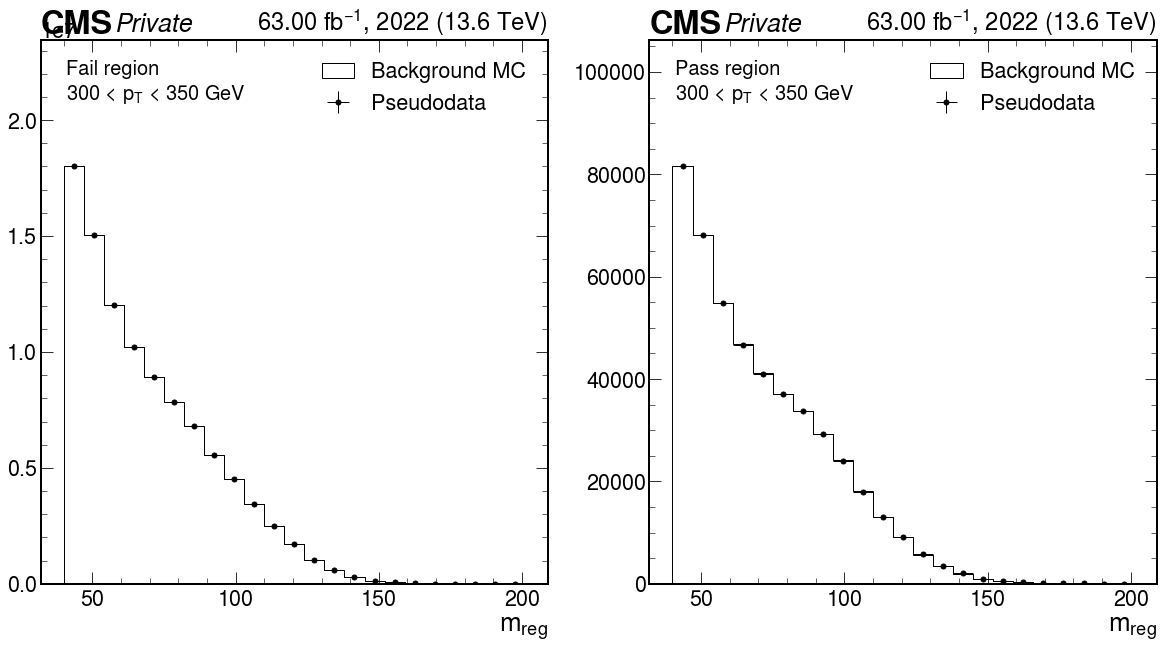

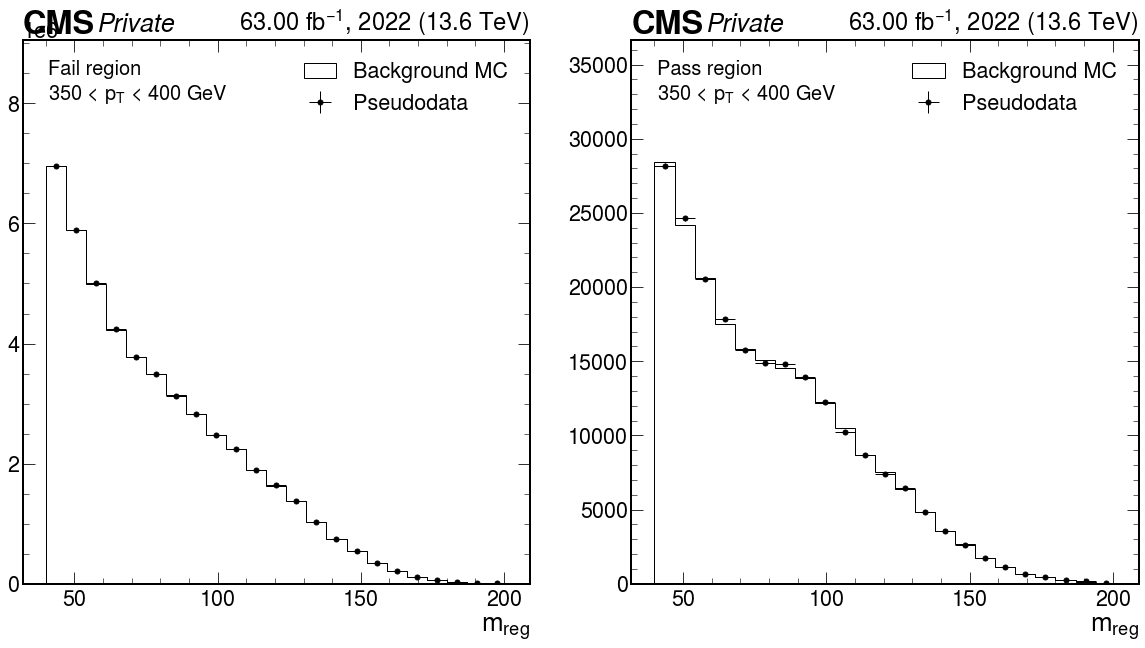

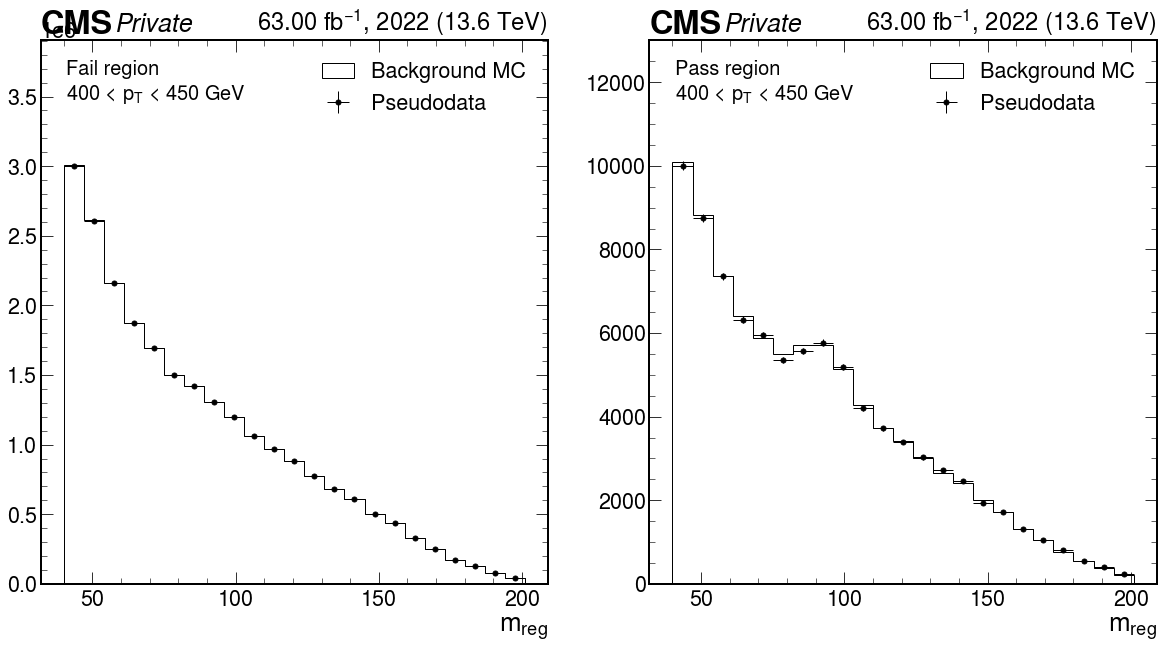

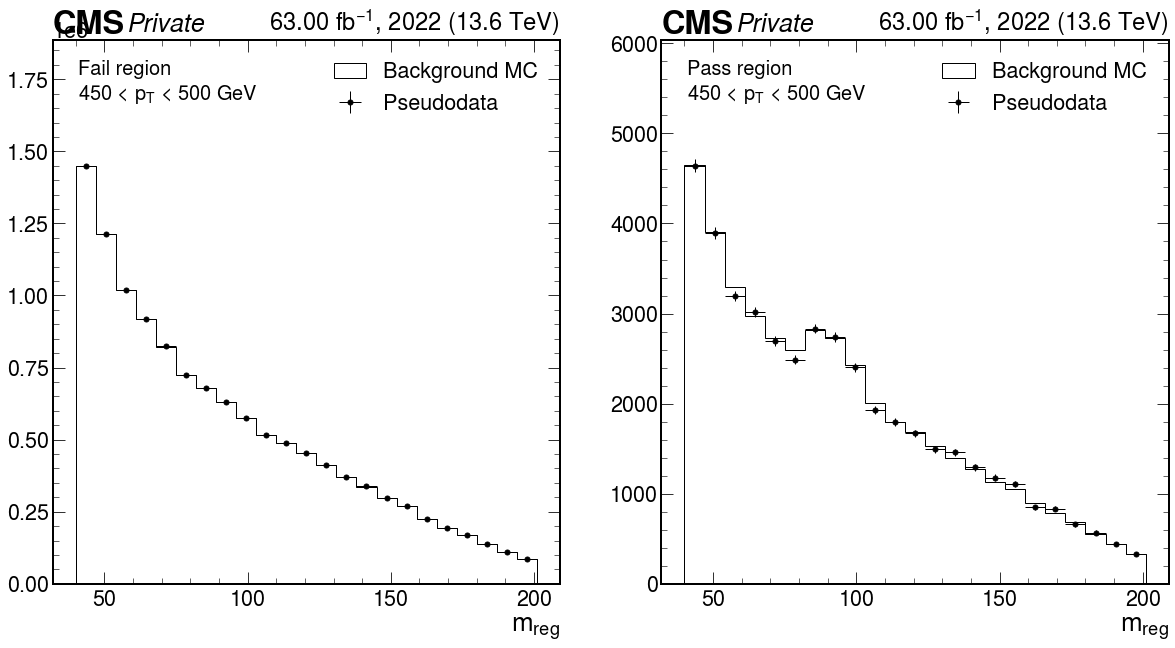

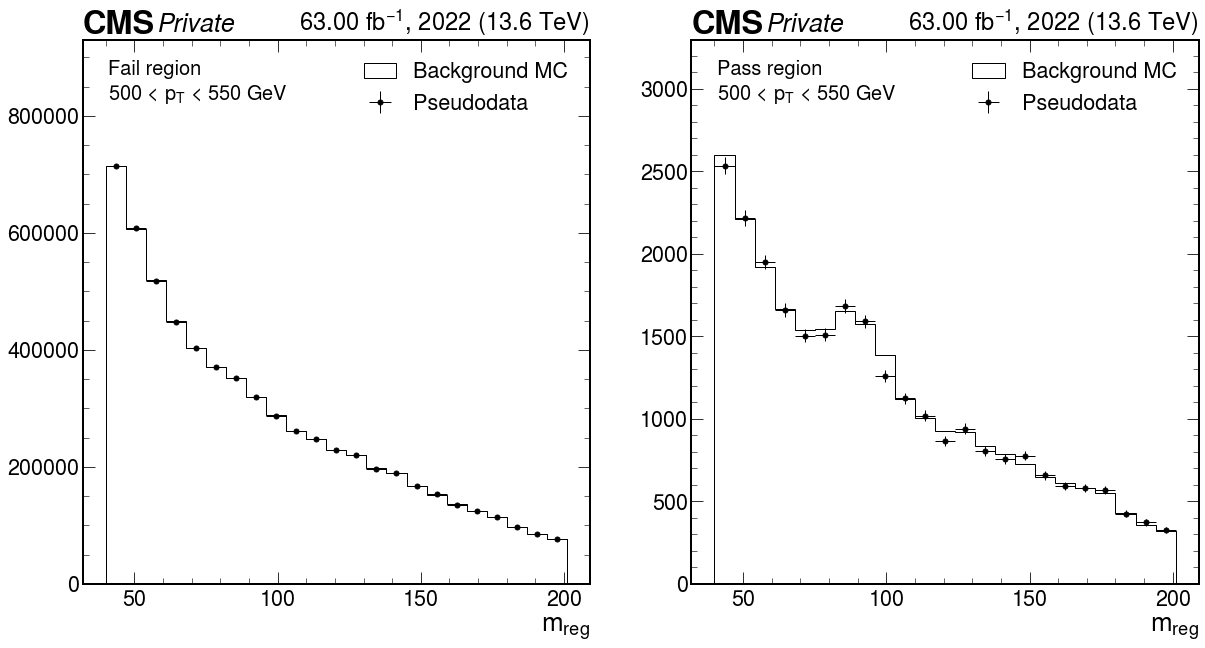

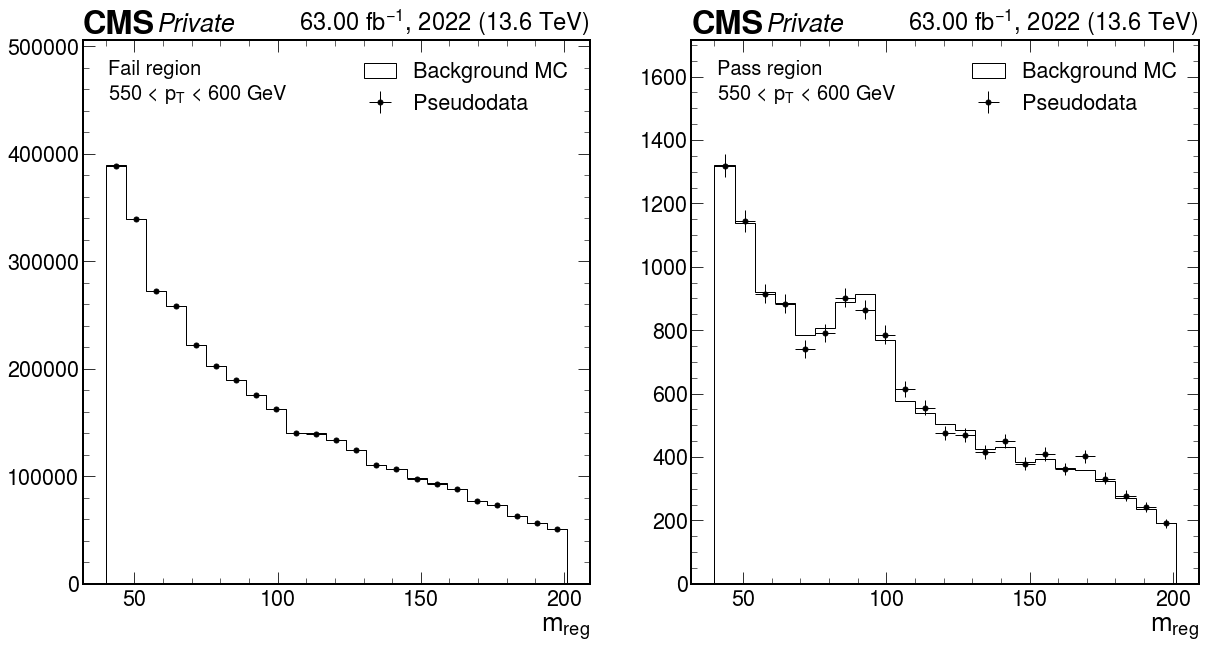

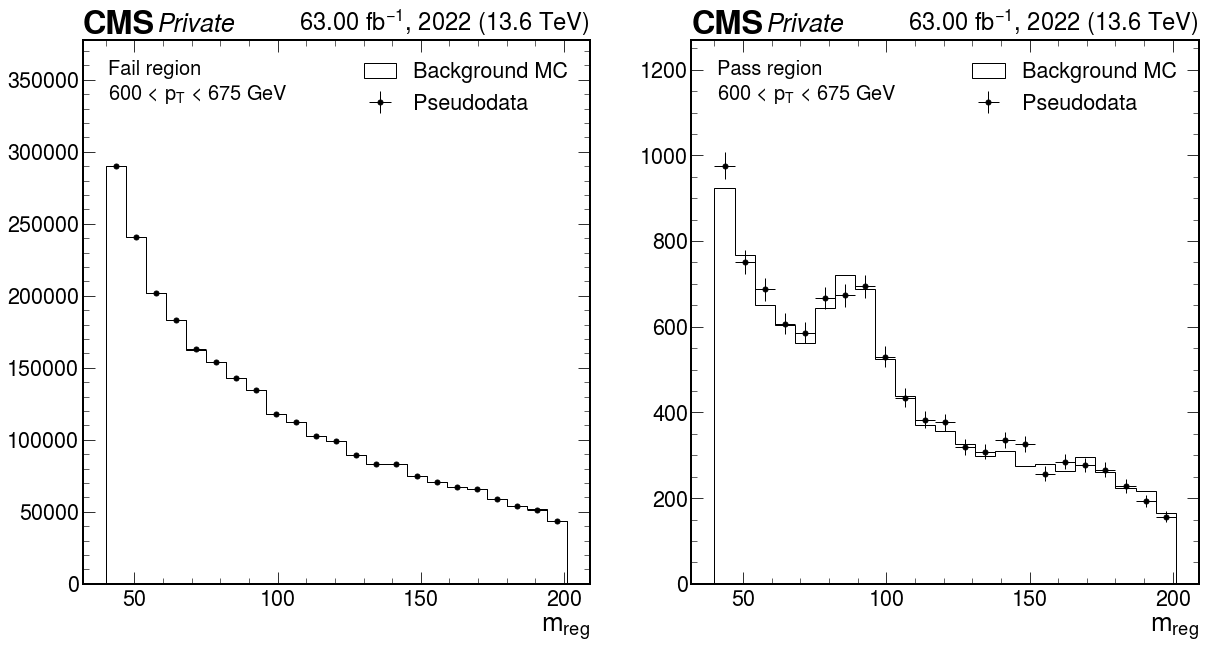

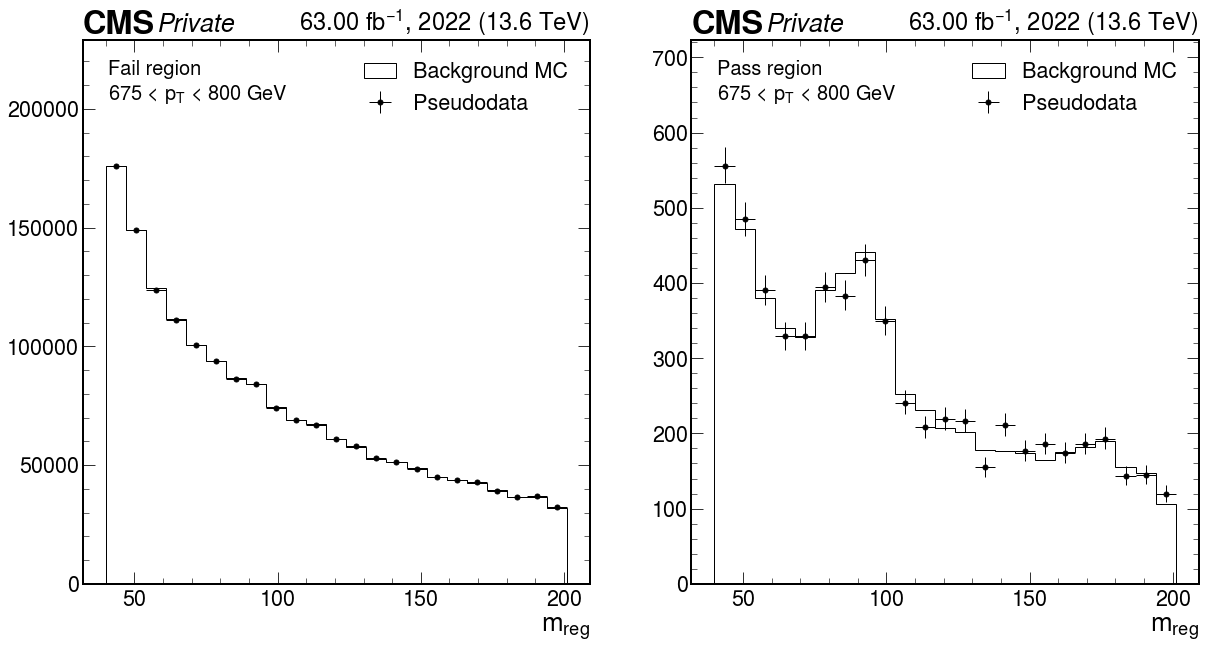

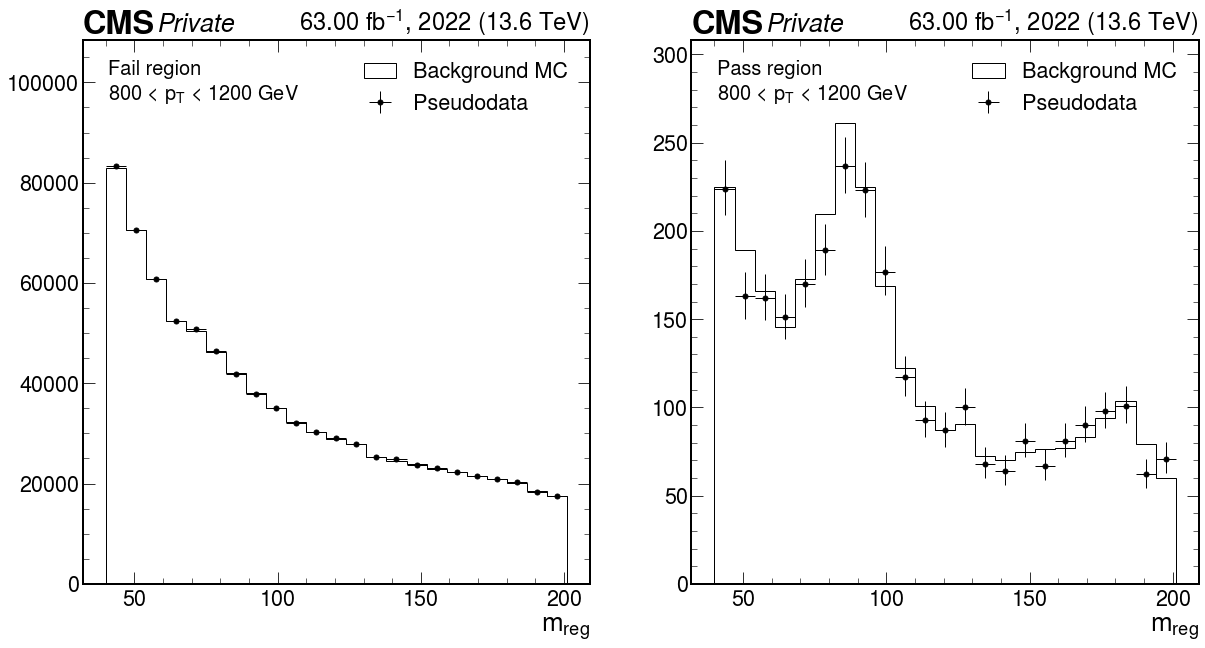

In [112]:
plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]

wp = 0.9859 #0.997 #0.9962

def get_region(h, region, pt1, pt2):
    
    h = h[{"pt" : slice(hist.loc(pt1), hist.loc(pt2), sum)}]
    
    if "Pass" in region:
        
        h_qcd = h[{'process' : hist.loc('QCD')}]
        h_qcd = h_qcd[:, 0:hist.loc(wp):sum] * (
            h_qcd[sum, hist.loc(wp):len:sum].value / h_qcd[sum, 0:hist.loc(wp):sum].value
        )
                
        h_rest = h[{
            'process' : [hist.loc('TTbar'), hist.loc('ZJets'), hist.loc('W'), hist.loc('Bkg. H'), hist.loc('VV')]
        }][{
            "disc" : slice(hist.loc(wp), len, sum), 
            "process" : slice(0, len, sum),
        }]
        
        h = h_qcd + h_rest
    else:
        h = h[{
            "disc" : slice(0, hist.loc(wp), sum), 
            "process" : slice(0, len, sum),
        }]
        
    return h

mchist = mc[{
    'process' : [hist.loc('TTbar'), hist.loc('QCD'), hist.loc('ZJets'), hist.loc('W'), hist.loc('Bkg. H'), hist.loc('VV')],
    'genflav': slice(0, len, sum),
    'cut' : -1,
}]

pickle_dict = {}

ptbins = [300, 350, 400, 450, 500, 550, 600, 675, 800, 1200]
for i, pt1 in enumerate(ptbins[:-1]):
    
    pt2 = ptbins[i+1]

    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(20, 10)
    )
    fig.subplots_adjust(hspace=0.1)

    for region, ax in [("Fail", ax1), ("Pass", ax2)]:

        ax.set_xlabel(r"$m_{reg}$")

        rhist = get_region(mchist, region, pt1, pt2)
        bin_values = rhist.axes[0].centers
        poisson_means = rhist.values()

        pseudodata = Hist(
            hist.axis.Regular(23, 40, 201, name="mass", label="Mass (GeV)"),
            storage=hist.storage.Weight(),
        )

        values = np.abs(np.repeat(bin_values, np.random.poisson(poisson_means)))
        pseudodata.fill(values)
        
#         ps_val = pseudodata.values()
#         ps_var = pseudodata.variances()
        
#         pseudodata[:] = np.append(ps_val[:, np.newaxis], ps_var[:, np.newaxis] * 5, axis=1)

        pickle_dict[f"ggf_{region.lower()}_pt"+str(i+1)+"_data_nominal"] = pseudodata

        mplhep.histplot(
            rhist,
            ax=ax,
            label="Background MC",
            color="white",
            histtype="fill",
            edgecolor="black",
            linewidth=1,
            flow="none",
        )

        mplhep.histplot(
            pseudodata, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Pseudodata",
            flow="none",
        )

        plt.text(0.05, 0.88, f"{region} region\n{pt1:.0f} < " + r"$p_T$" + f" < {pt2:.0f} GeV",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        mplhep.cms.label(
                ax=ax, 
                data=True, 
                fontsize=25,
                label="Private",
                year=2022,
                lumi=f"{lumi/1000:.2f}",
                com=13.6,
                )

        ax.legend(loc="upper right")
        ax.set_ylim(0, max(pseudodata.values()) * 1.3)

picklename = f"{out_dir}/pseudodata.pkl"
outfile = open(picklename, 'wb')
pickle.dump(pickle_dict, outfile, protocol=-1)
outfile.close()

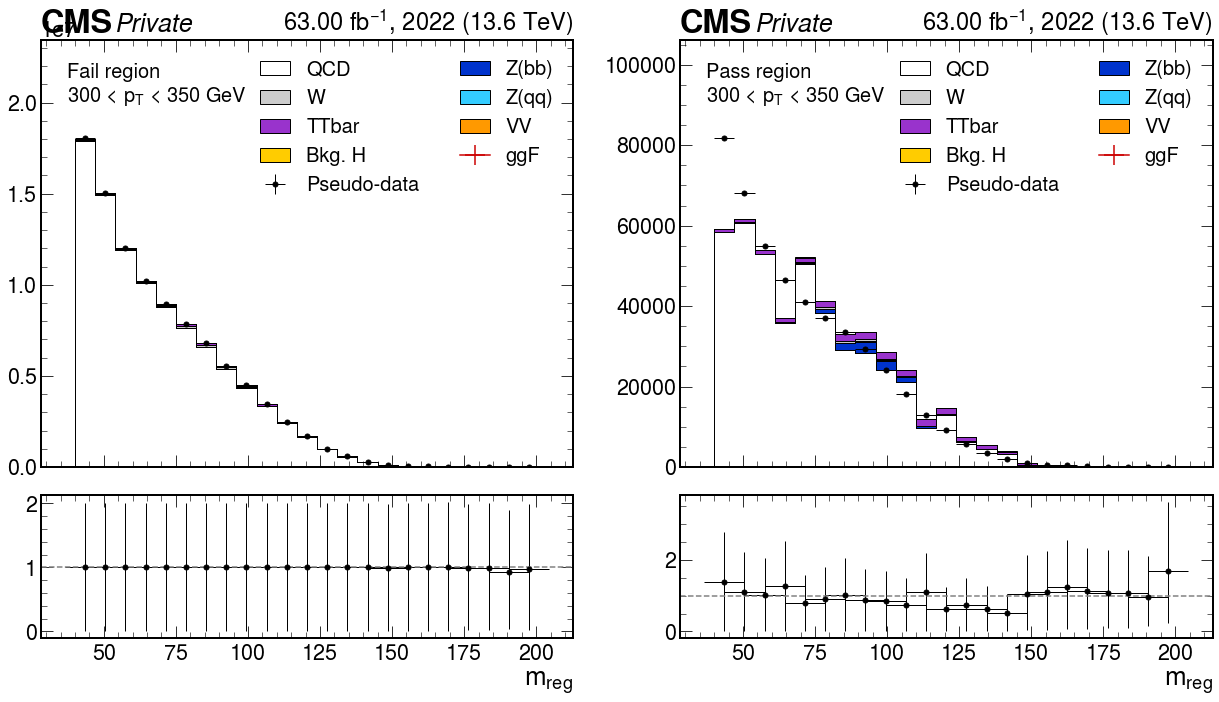

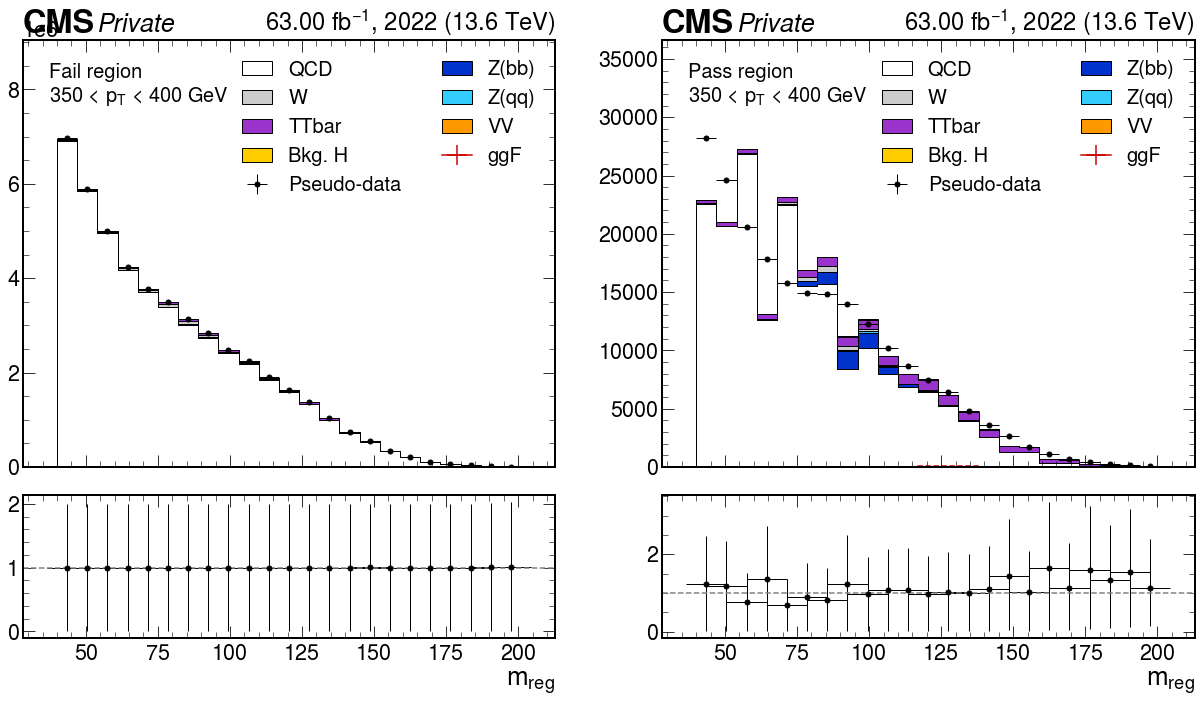

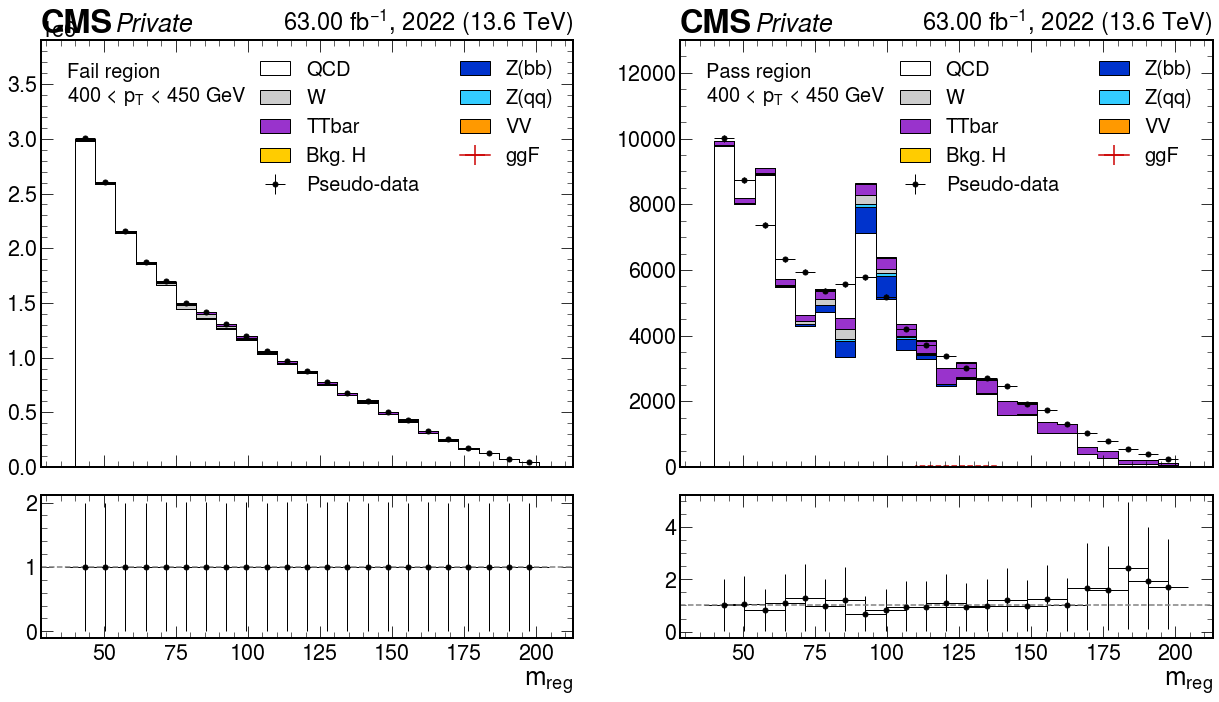

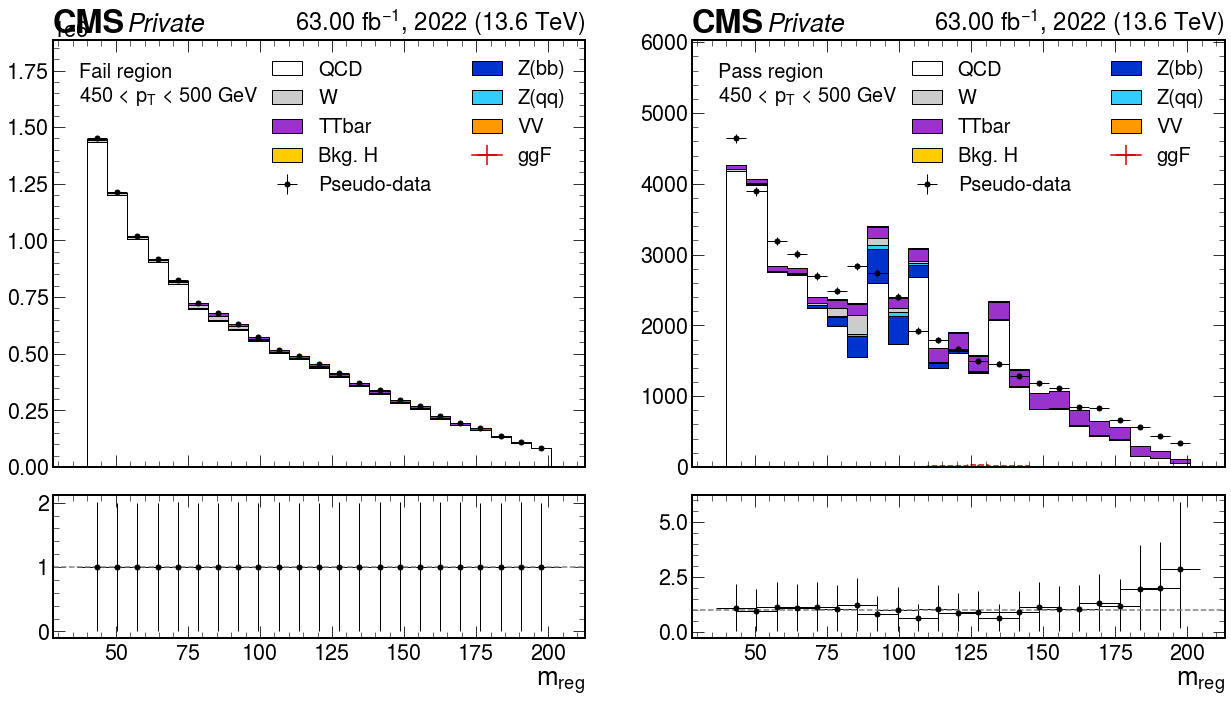

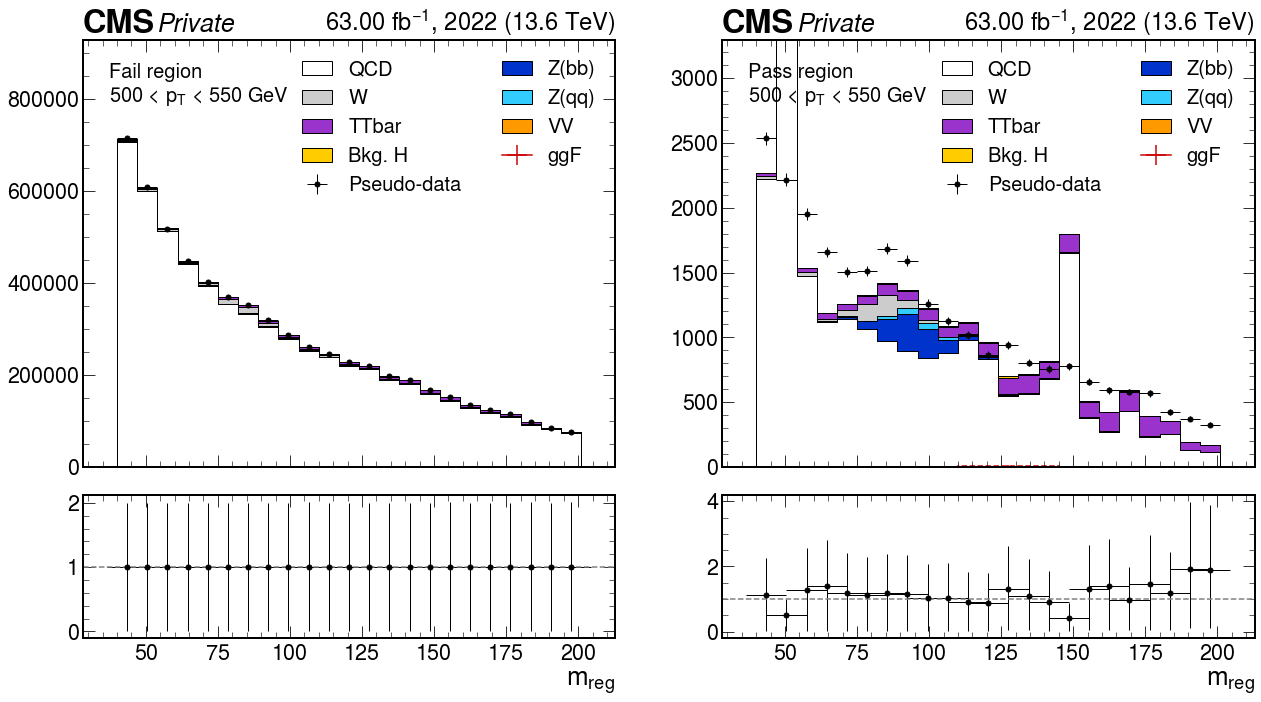

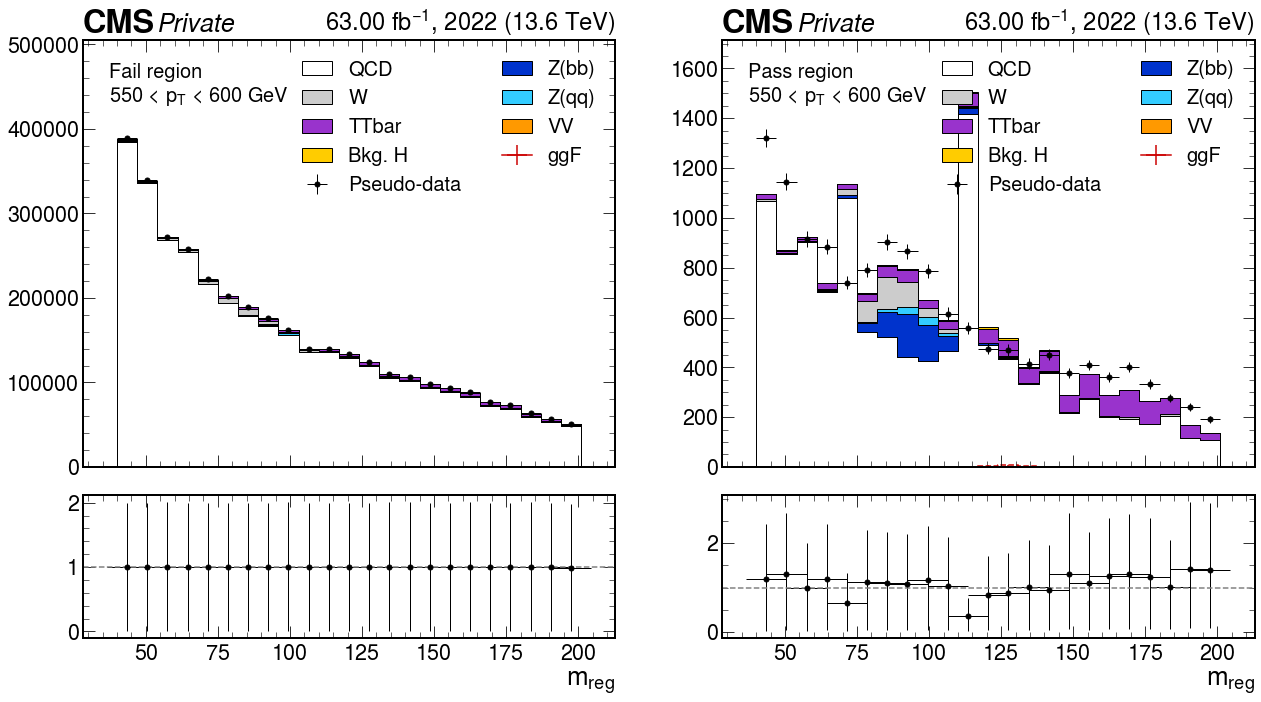

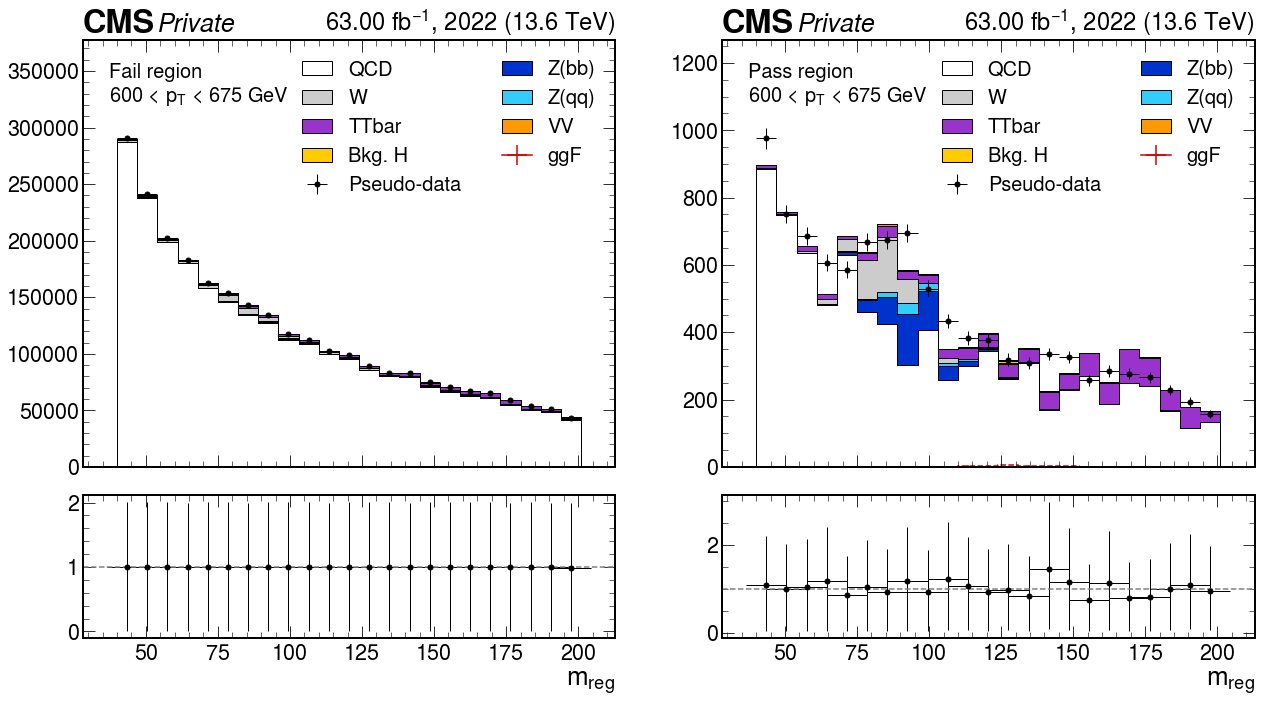

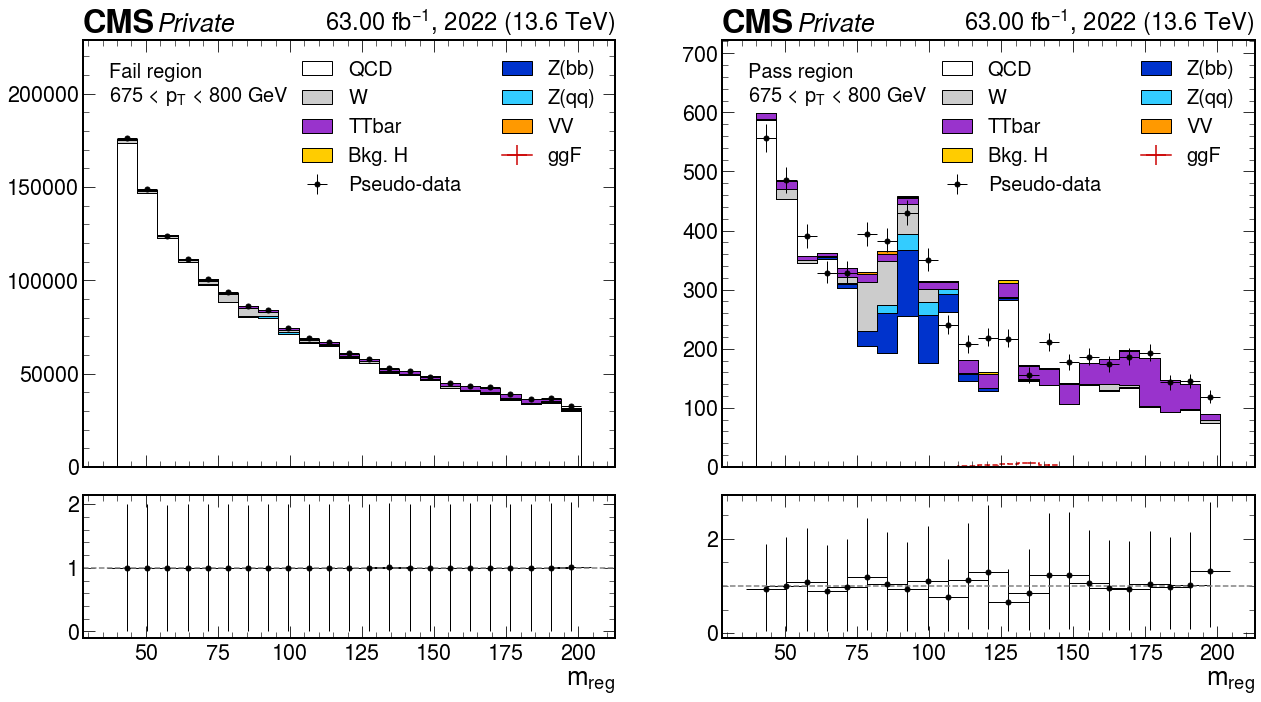

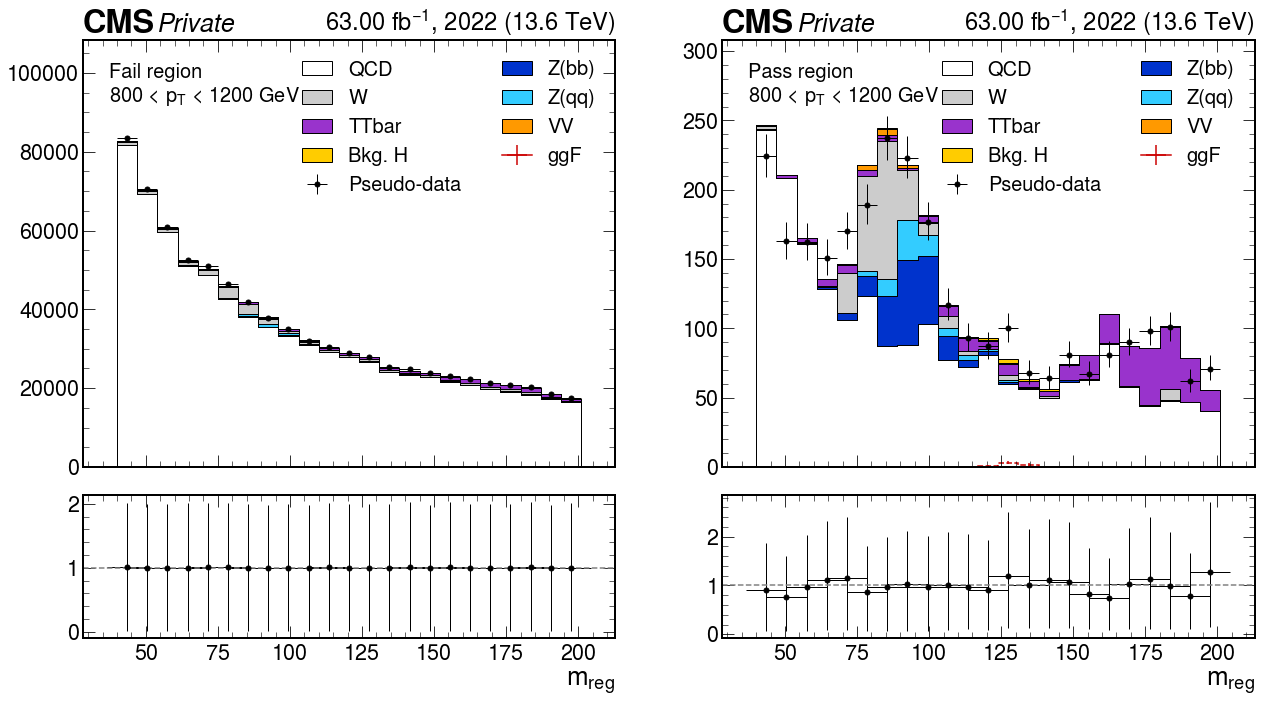

In [113]:
plt.style.use(mplhep.style.CMS)

mc = pickle.load(open(f'{out_dir}/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc["hist"]
data = pickle.load(open(f'{out_dir}/pseudodata.pkl','rb'))

colour = {
    "QCD" : "white",
    "Z(bb)" : "#0033cc",
    "Z(qq)" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
    "Bkg. H" : "#ffcc00",
}

wp = 0.9859 #0.997 #0.9962
blind = True

def get_region(h, region, process, pt1, pt2):
    
    h = h[{"pt" : slice(hist.loc(pt1), hist.loc(pt2), sum)}]
    
    if "Pass" in region:        
        if process == "QCD2":
            scale = h[:, hist.loc(wp):len:sum].sum().value / h[:, 0:hist.loc(wp):sum].sum().value
            h = h[:, 0:hist.loc(wp):sum] * scale
        else:
            h = h[:, hist.loc(wp):len:sum]
        
    else:
        h = h[:, 0:hist.loc(wp):sum]
        
    return h

for i, pt1 in enumerate(ptbins[:-1]):
    
    pt2 = ptbins[i+1]

    fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
        2, 2, figsize=(21, 11), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    
    for region, ax, rax in [("Fail", ax1, rax1), ("Pass", ax2, rax2)]:

        ax.set_xlabel(" ")
        rax.set_xlabel(r"$m_{reg}$")

        hs = []
        labels = []
        colours = []

        for process in colour.keys():

            h = mc.project("mass", "cut", "process", "disc", "genflav", "pt")

            if process[0] == "Z":
                if process == "Z(bb)":
                    h = h[:, -1, hist.loc("ZJets"), :, 3:4:sum, :]
                else:
                    h = h[:, -1, hist.loc("ZJets"), :, 1:3:sum, :]
            else:
                h = h[:, -1, hist.loc(process), :, 0:len:sum, :]

            h = get_region(h, region, process, pt1, pt2)

            hs.append(h)
            labels.append(process)
            colours.append(colour[process])

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
    #         sort="y_r",
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
            flow="none",
        )

        h = mc.project("mass", "cut", "process", "disc", "genflav", "pt")[
            :, -1, hist.loc("ggF"), :, 0:len:sum, :
        ]

        h = get_region(h, region, "ggF", pt1, pt2)

        mplhep.histplot(
            h, 
            ax=ax, 
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
            flow="none",
        )

        h = data[f"ggf_{region.lower()}_pt"+str(i+1)+"_data_nominal"]

        mplhep.histplot(
            h, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Pseudo-data",
            flow="none",
        )

        h_mc = mc.project("mass", "cut", "process", "disc", "genflav", "pt")[
            :, -1, 0:len:sum, :, 0:len:sum, :
        ]

        h_mc = get_region(h_mc, region, "All mc", pt1, pt2)

        centers = h.axes[0].centers
        sumw_num, sumw2_num = h.values(), h.variances()
        sumw_denom, sumw2_denom = h_mc.values(), h_mc.variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        rax.errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax.axhline(1, color='gray',ls='--')

        plt.text(0.05, 0.84, f"{region} region\n{pt1:.0f} < " + r"$p_T$" + f" < {pt2:.0f} GeV",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        mplhep.cms.label(
                ax=ax, 
                data=True, 
                fontsize=25,
                label="Private",
                year=2022,
                lumi=f"{lumi/1000:.2f}",
                com=13.6,
                )

        handles, labels = ax.get_legend_handles_labels()
        order = [0, 3, 4, 6, 8, 1, 2, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        if 'Pass' in region:
            ax.set_ylim(0, max(h.values()) * 1.3)
        else:
            ax.set_ylim(0, max(h.values()) * 1.3)

In [114]:
import shutil
import os

old_name = '../outfiles/Run3Summer22EE/roothist/5wp-9pt-hist-nodata.root'
new_name = '../outfiles/Run3Summer22EE/roothist/5wp-9pt-hist-pseudodata.root'

if os.path.isfile(new_name):
    os.remove(new_name)

shutil.copyfile(old_name, new_name)

uproot.open(old_name).keys()

data = pickle.load(open(f'{out_dir}/pseudodata.pkl','rb'))

for i, _ in enumerate(ptbins[:-1]):

    with uproot.update(new_name) as fout:
        fout["ggf_pass_pt"+str(i+1)+"_data_nominal"] = data[f"ggf_pass_pt"+str(i+1)+"_data_nominal"]
        fout["ggf_fail_pt"+str(i+1)+"_data_nominal"] = data[f"ggf_fail_pt"+str(i+1)+"_data_nominal"]

with uproot.open(new_name) as fin:
    for name in fin.keys():
        print(name)

ggf_pass_pt1_QCD_nominal;1
ggf_fail_pt1_QCD_nominal;1
ggf_pass_pt1_TTbar_nominal;1
ggf_fail_pt1_TTbar_nominal;1
ggf_pass_pt1_W_nominal;1
ggf_fail_pt1_W_nominal;1
ggf_pass_pt1_VV_nominal;1
ggf_fail_pt1_VV_nominal;1
ggf_pass_pt1_ggF_nominal;1
ggf_fail_pt1_ggF_nominal;1
ggf_pass_pt1_VBF_nominal;1
ggf_fail_pt1_VBF_nominal;1
ggf_pass_pt1_ZH_nominal;1
ggf_fail_pt1_ZH_nominal;1
ggf_pass_pt1_WH_nominal;1
ggf_fail_pt1_WH_nominal;1
ggf_pass_pt1_ttH_nominal;1
ggf_fail_pt1_ttH_nominal;1
ggf_pass_pt1_ZJetsqq_nominal;1
ggf_fail_pt1_ZJetsqq_nominal;1
ggf_pass_pt1_ZJetsbb_nominal;1
ggf_fail_pt1_ZJetsbb_nominal;1
ggf_pass_pt2_QCD_nominal;1
ggf_fail_pt2_QCD_nominal;1
ggf_pass_pt2_TTbar_nominal;1
ggf_fail_pt2_TTbar_nominal;1
ggf_pass_pt2_W_nominal;1
ggf_fail_pt2_W_nominal;1
ggf_pass_pt2_VV_nominal;1
ggf_fail_pt2_VV_nominal;1
ggf_pass_pt2_ggF_nominal;1
ggf_fail_pt2_ggF_nominal;1
ggf_pass_pt2_VBF_nominal;1
ggf_fail_pt2_VBF_nominal;1
ggf_pass_pt2_ZH_nominal;1
ggf_fail_pt2_ZH_nominal;1
ggf_pass_pt2_WH_nomina

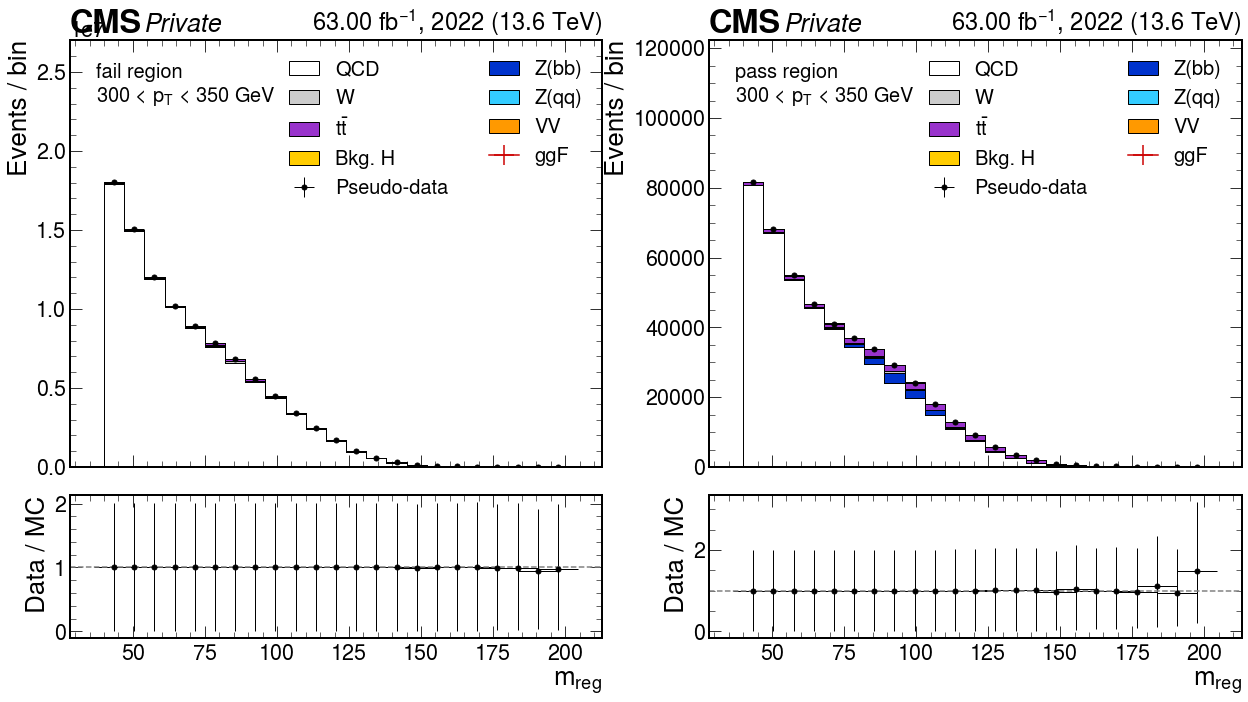

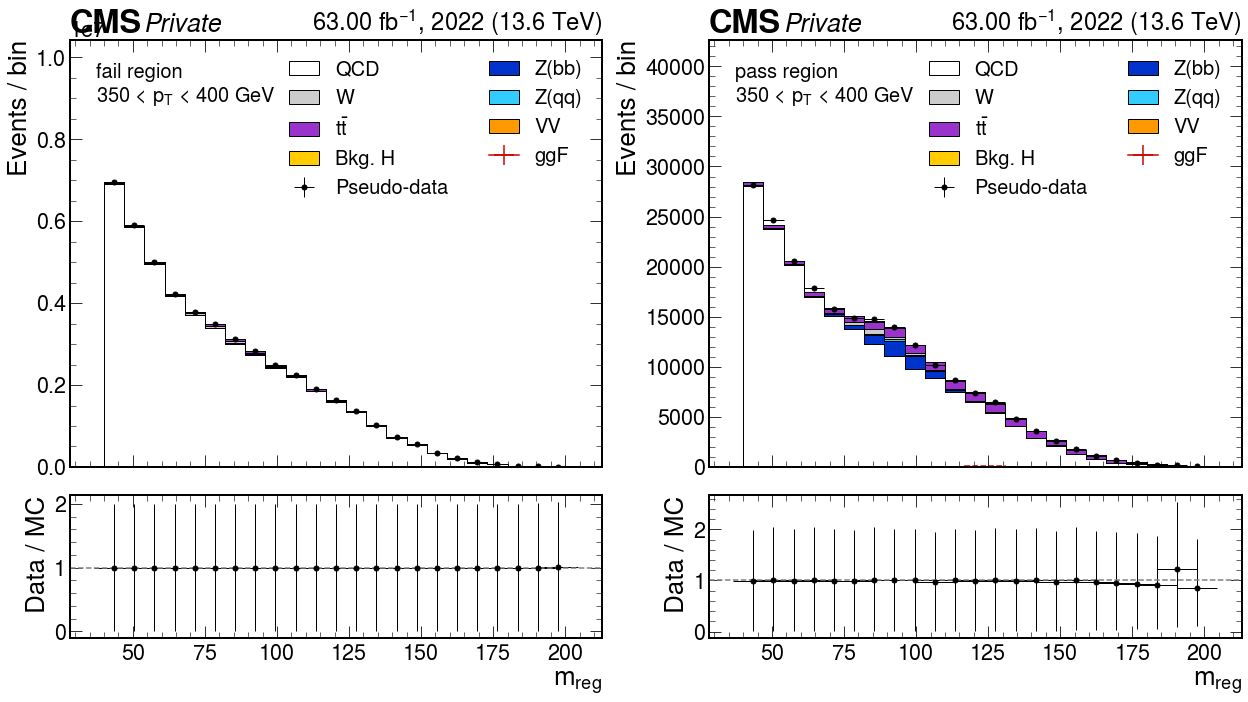

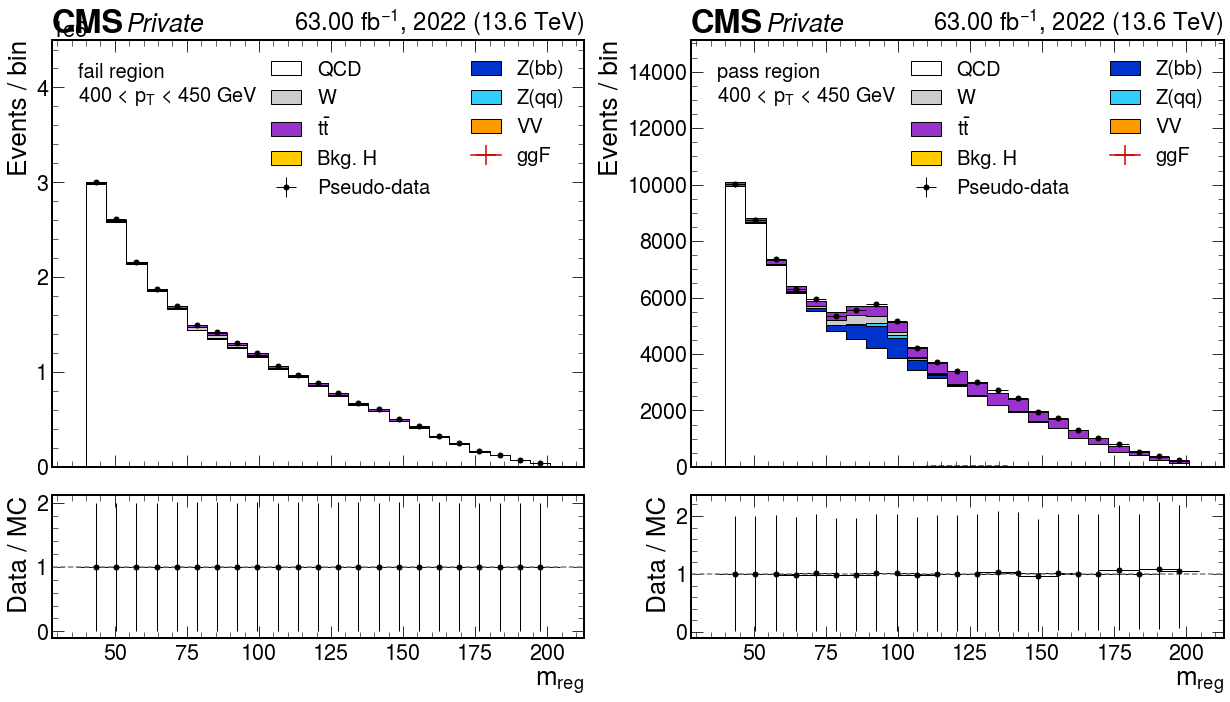

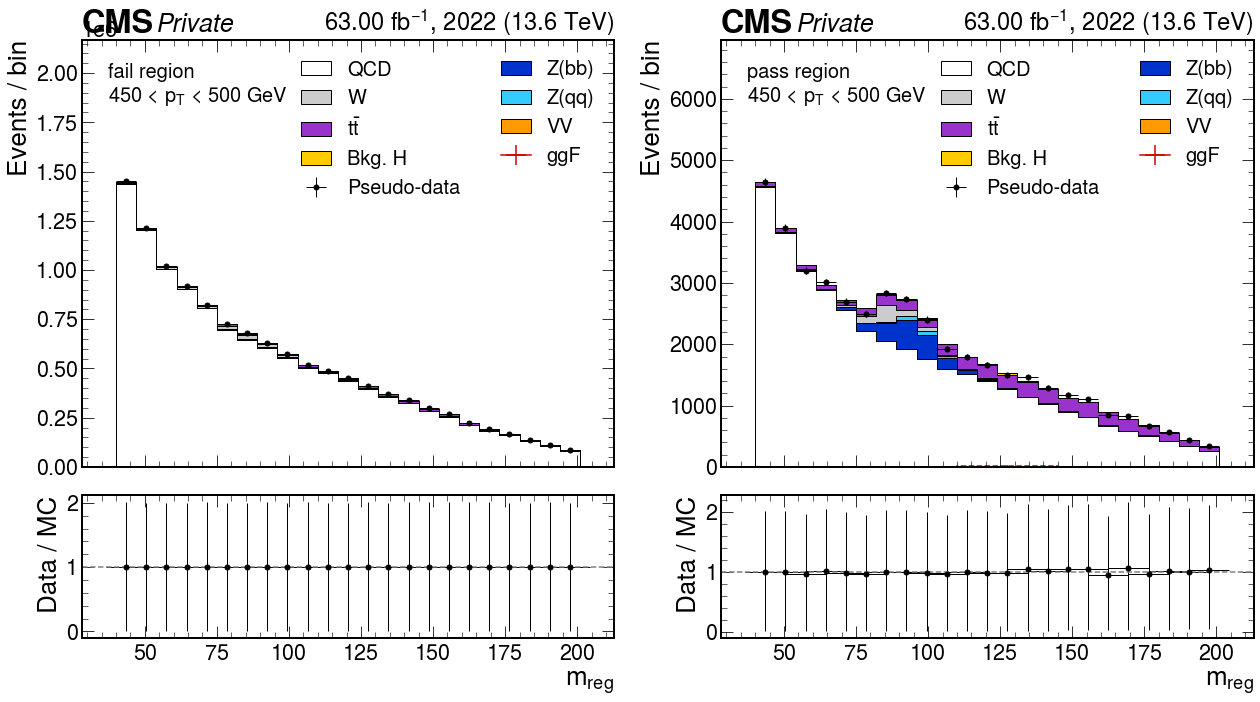

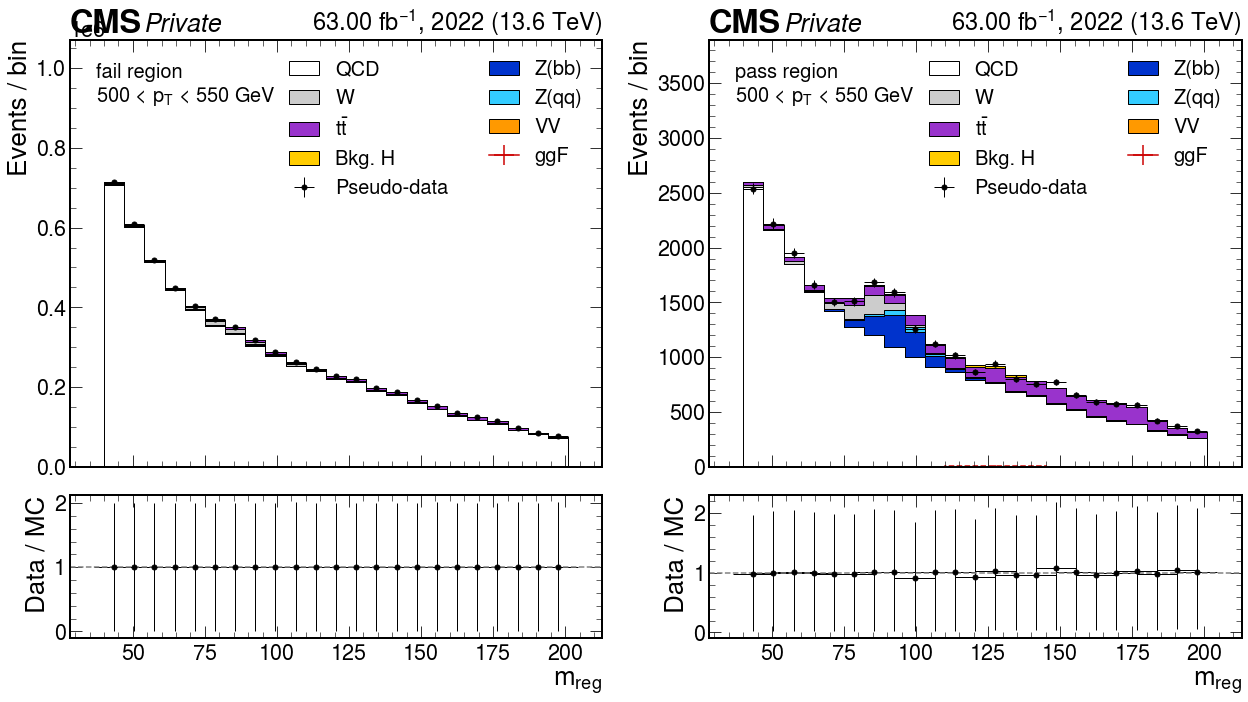

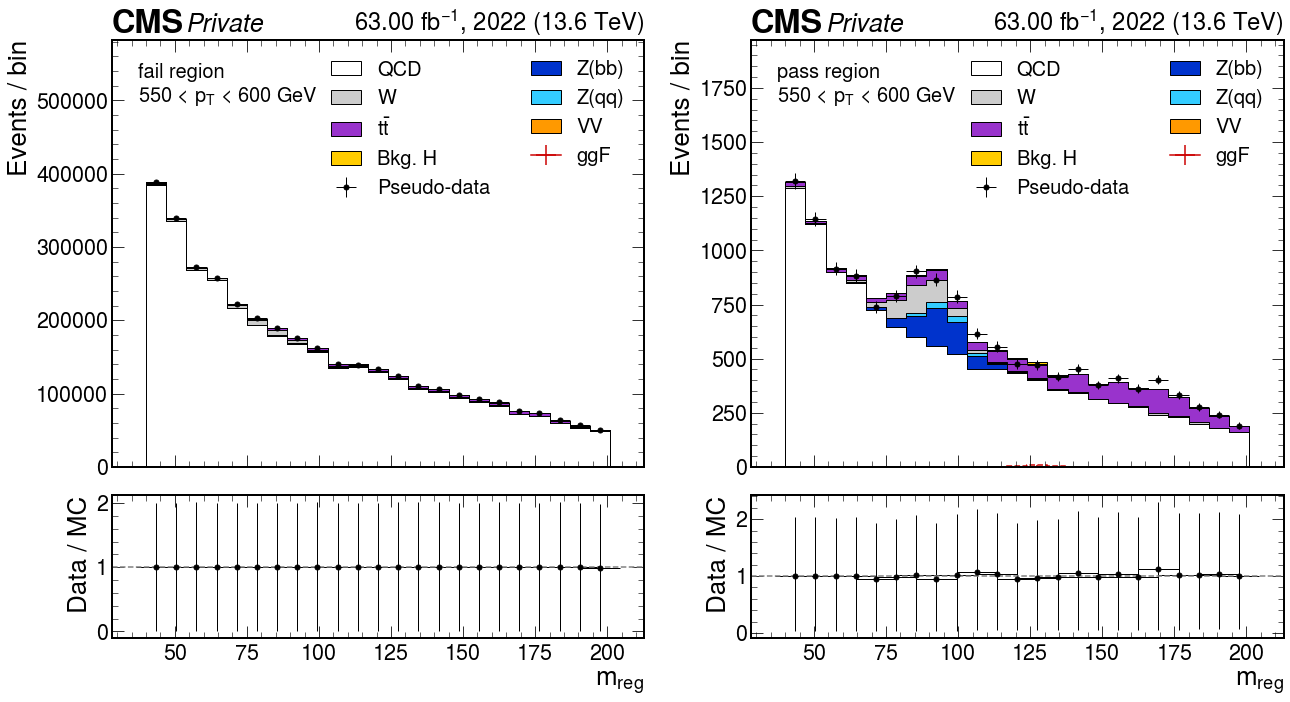

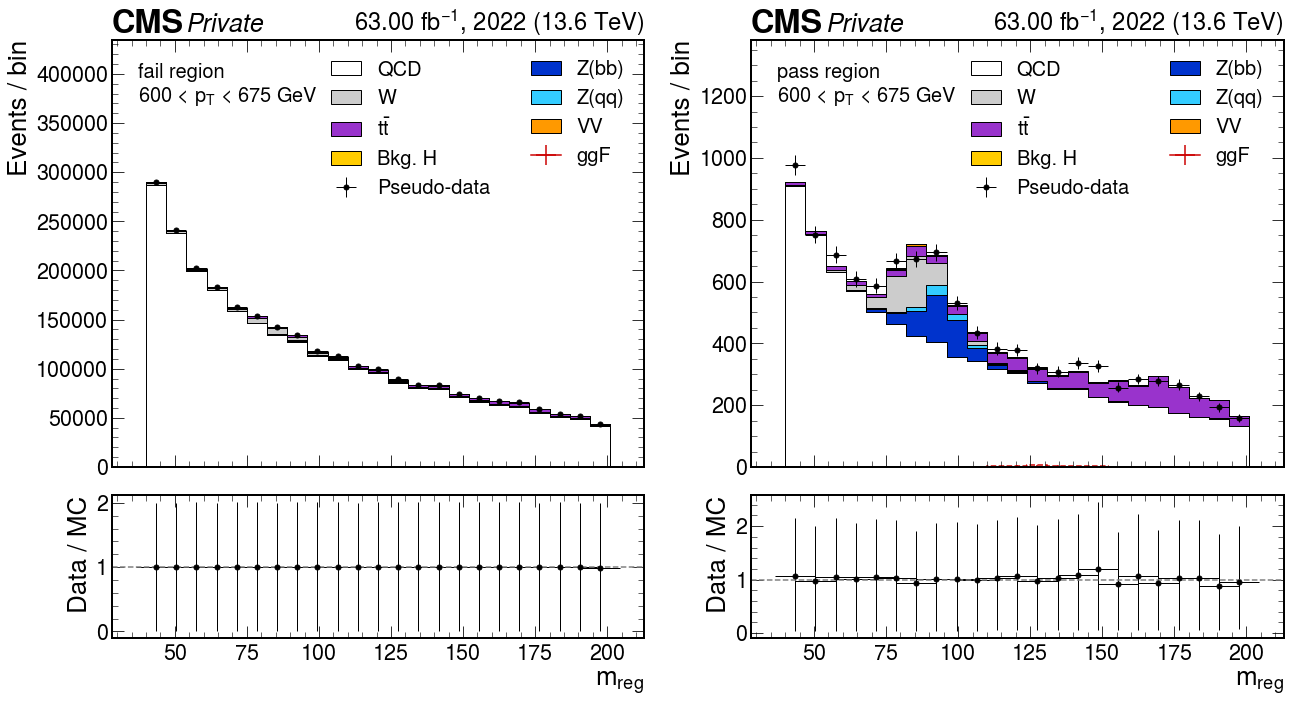

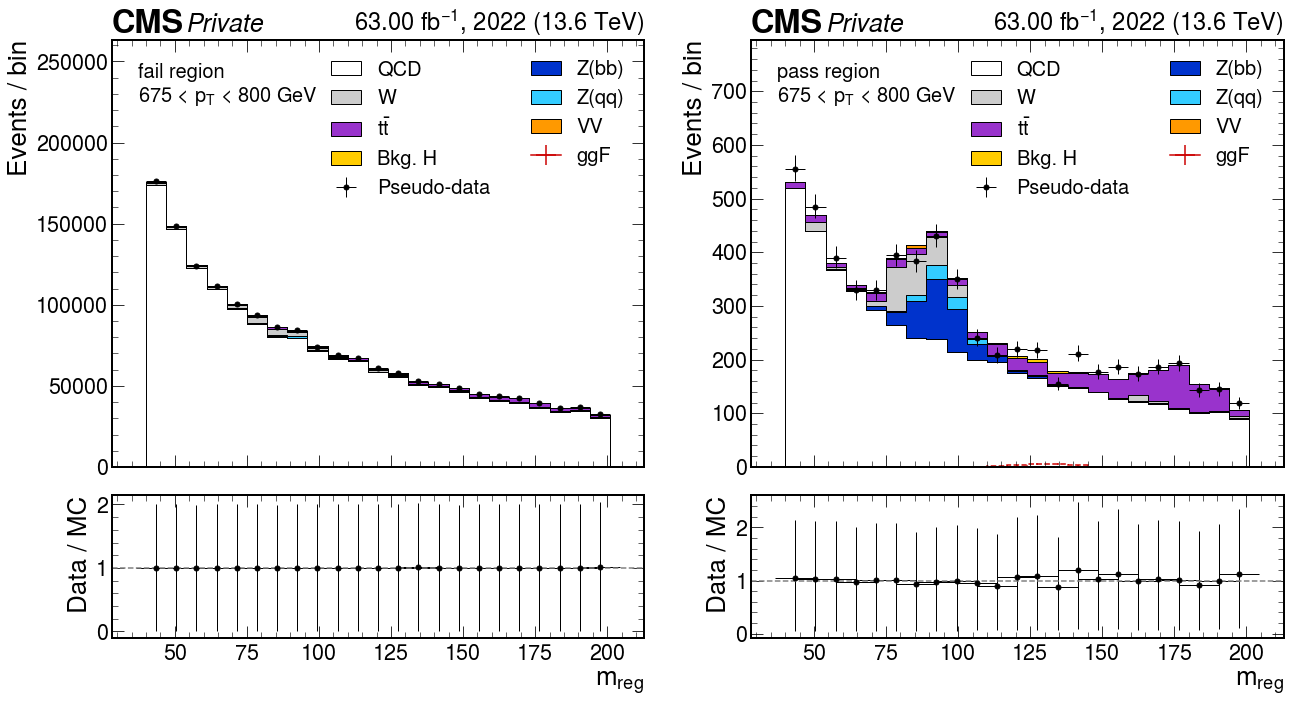

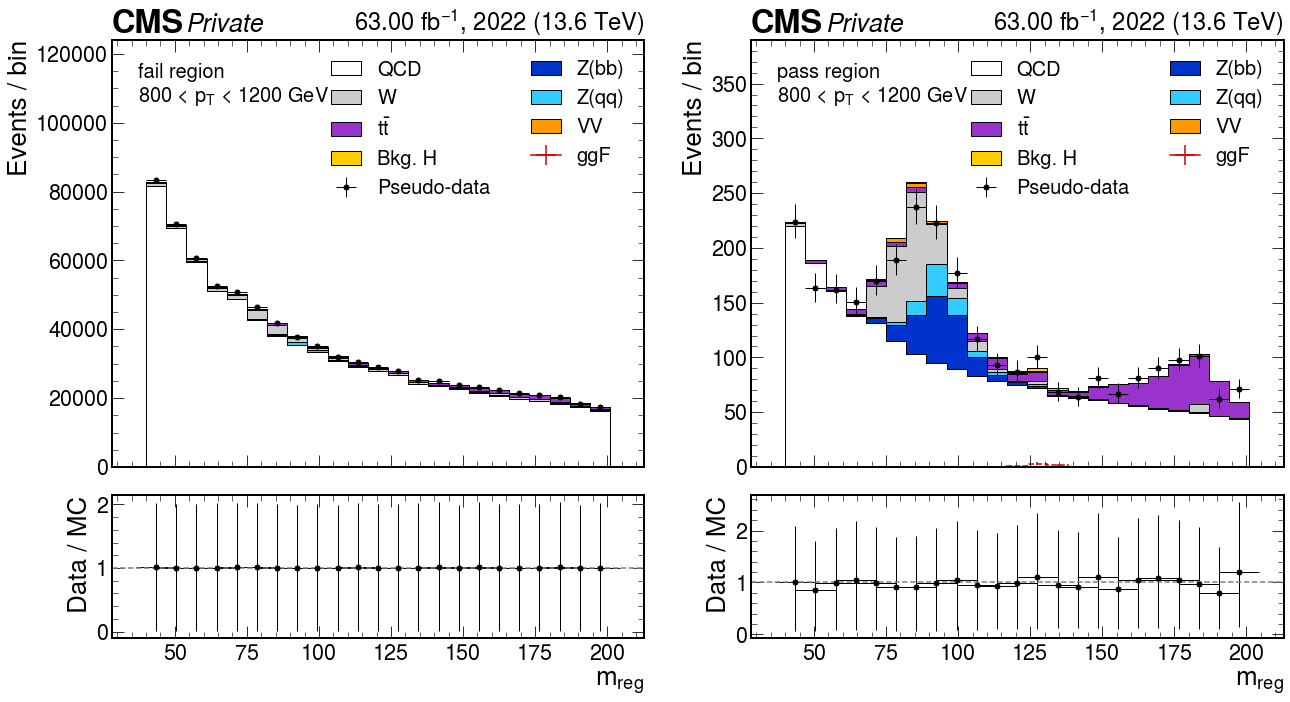

In [115]:
plt.style.use(mplhep.style.CMS)

colour = {
    "QCD" : "white",
    "ZJetsbb" : "#0033cc",
    "ZJetsqq" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
#     "Single t" : "#ff66cc",
    "VV" : "#ff9900",
}

label = {
    "QCD" : "QCD",
    "ZJetsbb" : "Z(bb)",
    "ZJetsqq" : "Z(qq)",
    "W" : "W",
    "TTbar" : r"$t\bar{t}$",
    "Single t" : "Single t",
    "VV" : "VV",
}

f = uproot.open(new_name)

for i, pt1 in enumerate(ptbins[:-1]):
    
    pt2 = ptbins[i+1]
    
    fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
        2, 2, figsize=(21, 11), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)
    
    for region, ax, rax in [("fail", ax1, rax1), ("pass", ax2, rax2)]:
    
        hs = []
        labels = []
        colours = []

        ax.set_ylabel("Events / bin")
        rax.set_ylabel("Data / MC")
        rax.set_xlabel(r"m$_{reg}$")
        ax.set_xlabel(" ")

        for process in colour.keys():

            h = f[f'ggf_{region}_pt{i+1}_{process}_nominal'].to_hist()

            hs.append(h)
            labels.append(label[process])
            colours.append(colour[process])

        higgs_h = None

        for process in ['VBF', 'ZH', 'WH', 'ttH']:

            h = f[f'ggf_{region}_pt{i+1}_{process}_nominal'].to_hist()

            if not higgs_h:
                higgs_h = h
            else:
                higgs_h += h

        hs.append(higgs_h)
        labels.append("Bkg. H")
        colours.append("#ffcc00")

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
            flow="none",
        )

        h = f[f'ggf_{region}_pt{i+1}_ggF_nominal'].to_hist()

        mplhep.histplot(
            h, 
            ax=ax,
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
            flow="none",
        )

        h = f[f'ggf_{region}_pt{i+1}_data_nominal'].to_hist()

        mplhep.histplot(
            h, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Pseudo-data",
            flow="none",
        )

        hs_mc = None
        for h_mc in hs:
            if not hs_mc:
                hs_mc = h_mc
            else:
                hs_mc += h_mc

        centers = h.axes[0].centers
        sumw_num, sumw2_num = h.values(), h.variances()
        sumw_denom, sumw2_denom = hs_mc.values(), hs_mc.variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        rax.errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax.axhline(1, color='gray',ls='--')

        mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Private",
            year=2022,
            lumi=f"{lumi/1000:.2f}",
            com=13.6,
        )
        
        plt.text(0.05, 0.84, f"{region} region\n{pt1:.0f} < " + r"$p_T$" + f" < {pt2:.0f} GeV",
                    fontsize=20,
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    transform=ax.transAxes
                   )

        handles, labels = ax.get_legend_handles_labels()
        order = [0, 3, 4, 6, 8, 1, 2, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(hs[0].values()) * 1.5)